In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils.validation import check_is_fitted

In [49]:
def wrangle(file):
    conn = sqlite3.connect(file)

    query =  """
    select distinct(i.building_id) as b_id, b.*, bd.damage_grade from id_map i
    join building_structure b
    on i.building_id = b.building_id
    join building_damage bd
    on i.building_id = bd.building_id
    where i.district_id = 28
    """

    df = pd.read_sql(query, conn, index_col='b_id')

    drop_cols = [col for col in df.columns if 'post_eq' in col]

    df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
    df['severe_grade'] = (df['damage_grade']>3).astype(int)

    

In [67]:
df.head()

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,severe_grade
b_id,,,,,,,,,,,,
2.801020e+11,7,2,1,14,0,2,6,200,3,1,5,1
2.801010e+11,18,2,1,15,1,3,6,450,3,1,5,0
2.801010e+11,20,2,1,15,1,3,6,500,3,1,5,1
2.801010e+11,21,2,1,24,1,3,6,350,3,1,5,0
2.801010e+11,20,2,1,24,1,2,6,280,0,1,5,1


In [52]:
df.shape

(77148, 12)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77148 entries, 280102000961.0 to 286209000691.0
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            77148 non-null  int64 
 1   foundation_type         77148 non-null  object
 2   ground_floor_type       77148 non-null  object
 3   height_ft_pre_eq        77148 non-null  int64 
 4   land_surface_condition  77148 non-null  object
 5   other_floor_type        77148 non-null  object
 6   plan_configuration      77148 non-null  object
 7   plinth_area_sq_ft       77148 non-null  int64 
 8   position                77148 non-null  object
 9   roof_type               77148 non-null  object
 10  superstructure          77148 non-null  object
 11  severe_grade            77148 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.7+ MB


In [54]:
from collections import Counter

In [55]:
counter = Counter(df['severe_grade'])
counter

Counter({1: 63579, 0: 13569})

In [56]:
foundation_measure = pd.pivot_table(
    df, index = 'foundation_type', values = 'severe_grade', aggfunc = 'mean'
).sort_values(by = 'severe_grade')
foundation_measure

,severe_grade
foundation_type,
RC,0.050481
Other,0.247863
Bamboo/Timber,0.454545
Cement-Stone/Brick,0.593092
Mud mortar-Stone/Brick,0.866976


In [57]:
major, minor = df.severe_grade.value_counts(normalize=True)

major, minor

(0.8241172810701509, 0.1758827189298491)

<Figure size 1200x1200 with 0 Axes>

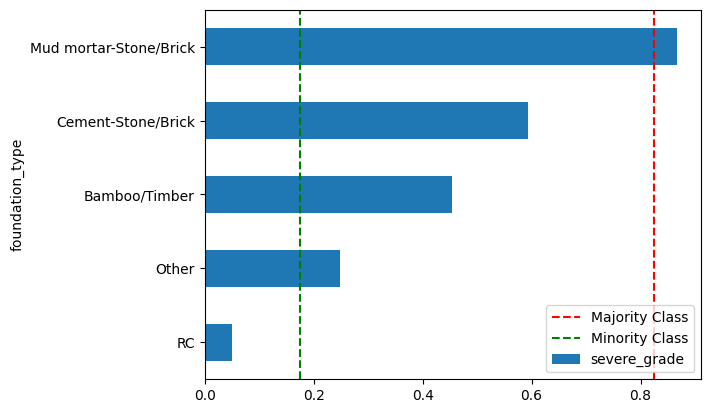

In [58]:
plt.figure(figsize=(12, 12))
foundation_measure.plot(kind='barh')
plt.axvline(
    major, linestyle = '--', color='red', label='Majority Class'
)
plt.axvline(
    minor, linestyle = '--', color='green', label='Minority Class'
)
plt.legend(loc= 'lower right')
plt.show()

In [69]:
X = df.drop(['severe_grade'], axis=1)
y = df['severe_grade']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [61]:
col = []

for i in df.columns:
    if df[i].dtype=='object':
        col.append(i)
col

['foundation_type',
 'ground_floor_type',
 'land_surface_condition',
 'other_floor_type',
 'plan_configuration',
 'position',
 'roof_type',
 'superstructure']

In [62]:
le = LabelEncoder()

In [65]:
for co in col:
    df[co]=le.fit_transform(df[co])
    print(le.classes_)

[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2]
[0 1 2 3]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10]


In [71]:
smote = SMOTE(random_state=30)

X_resample_smote,y_resample_smote = smote.fit_resample(X,y)

In [73]:
len(X_resample_smote), len(y_resample_smote)

(127158, 127158)

In [74]:
X = X_resample_smote
y = y_resample_smote

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [76]:
from sklearn.preprocessing import StandardScaler

In [79]:
model = Pipeline(
    [
        ('ss', StandardScaler()),
        ('lr', DecisionTreeClassifier())
    ]                  
)    

In [80]:
model.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('lr', DecisionTreeClassifier())])

In [81]:
accuracy_score(y_train, model.predict(X_train))

0.9748736802783949

In [84]:
check_is_fitted(model)

In [85]:
model.score(X_train, y_train)

0.9748736802783949

In [86]:
accuracy_score(y_test, model.predict(X_test))

0.8251415539477823